In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
%matplotlib inline

In [109]:
INPUTPATH = 'Influx Data - JPL/JPL-EV-L2-57_Actual.csv'
INPUTPATH2 = 'Influx Data - JPL/JPL-EV-L2-57_Allocation.csv'

def get_timeseries(path):
    df = pd.read_csv(path)
#     df = df.loc[df['name'] == 'mamps_actual']
    df = pd.to_numeric(df.value, errors='coerce')
    df = df.dropna()
    timeseries = df.tolist()
    return list(map(int, timeseries))

def get_decay(sub):
    if 2 * len(sub)/3 % 2 ==0:
        ks = 1 + 2 * len(sub)/3
    else:
        ks = 2 * len(sub)/3

    clean = signal.medfilt(sub, kernel_size=ks)
    
    mx_diff = 0
    mx_ind = 0
    for i in range(51, len(clean) - 52):
        slope1 = (clean[i+1] - clean[i-1]) / 2
        slope2 = (clean[i+50] - clean[i-50]) / 100
        if (slope2 < 0) and abs(slope1 - slope2) > mx_diff:
            mx_diff = abs(slope1 - slope2)
            mx_ind = i
    
    return clean[mx_ind:]

def split_timeseries(ts):
    ts_splits = []
    curr_start = -1
    num_zeros = 0
    in_curr = False
    for i in range(len(ts)):
        if ts[i] > 0 and not in_curr:
            curr_start = i
            in_curr = True
        elif ts[i] <= 100 and in_curr:
            if ts[i-1] > 0:
                num_zeros = 0
            num_zeros += 1
            if num_zeros == 2:
                if (i - curr_start > 100) and np.max(ts[curr_start:i]) > 2000:
#                     ind = get_decay_index(ts[curr_start:i])
                    ts_splits.append(get_decay(ts[curr_start:i]))
                num_zeros = 0
                in_curr = False

    return ts_splits


ts = get_timeseries(INPUTPATH)
data = split_timeseries(ts)

ts2 = get_timeseries(INPUTPATH2)
data2 = split_timeseries(ts2)

In [117]:
sub = data[18]
sub_scaled = []

for i in range(len(sub)):
    if sub[i] != 0:
        sub_scaled.append( np.log(sub[i]) )
    else:
        sub_scaled.append( 0 )

def lin(x, a, b):
    return a*x + b

xx = np.linspace(0,len(sub), num=len(sub))
# print xx
popt, pcov = sp.optimize.curve_fit(lin, xx, sub_scaled)

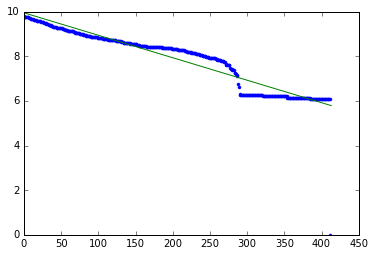

In [118]:
xx = np.linspace(0,len(sub), num=len(sub) )
yy = lin(xx, *popt)
#print yy
plt.plot(sub_scaled, '.')
plt.plot(xx,yy)
plt.show()